In [2]:
import pandas as pd
import h5py
from tqdm import tqdm
import h5py
import numpy as np

# Load Data

In [3]:
filename = '../data/9606.protein.network.embeddings.v12.0 (1).h5'

with h5py.File(filename, 'r') as f:
    meta_keys = f['metadata'].attrs.keys()
    for key in meta_keys:
        print(key, f['metadata'].attrs[key])
    
    embedding = f['embeddings'][:]
    proteins = f['proteins'][:]
    proteins = [p.decode('utf-8') for p in proteins]

# Create DataFrame with one column containing the vector arrays
network_vector_df = pd.DataFrame({
    'embedding_vector': [np.array(vec) for vec in embedding]
}, index=proteins)

enrichment_df = pd.read_csv('../data/9606.protein.enrichment.terms.v12.0.txt.gz', 
                          sep='\t',  
                          compression='gzip')

enrichment_df.set_index('#string_protein_id', inplace=True)

go_categories = [
    'Biological Process (Gene Ontology)',
]

go_enrichment_df = enrichment_df[enrichment_df['category'].isin(go_categories)]


embedding_dim 512
n_proteins 19699
precision 16


# Combine Data

In [4]:
# First create mapping of GO descriptions for proteins that have them
go_descriptions = go_enrichment_df.groupby(level=0)['description'].agg(lambda x: list(set(x)))

# Calculate frequency of each GO term (counting once per protein)
term_frequencies = {}
total_proteins = len(go_descriptions)
for terms in go_descriptions:
    unique_terms = set(terms)
    for term in unique_terms:
        term_frequencies[term] = term_frequencies.get(term, 0) + 1

# Convert to percentages
term_percentages = {term: count/total_proteins for term, count in term_frequencies.items()}

# Find terms that appear in more than 5% of proteins
common_terms = {term for term, percentage in term_percentages.items() if percentage > 0.005}

# Filter out common terms
def filter_common_terms(terms):
    return [term for term in terms if term not in common_terms]

# Apply filtering
filtered_go_descriptions = go_descriptions.apply(filter_common_terms)

# Create binary vectors for remaining terms
all_go_terms = sorted(set(term for terms in filtered_go_descriptions for term in terms))
term_to_idx = {term: idx for idx, term in enumerate(all_go_terms)}

def terms_to_binary_vector(terms):
    vector = [0] * len(all_go_terms)
    if isinstance(terms, (list, set, tuple)):
        for term in terms:
            if term in term_to_idx:
                vector[term_to_idx[term]] = 1
    return vector

# Create vectors for all proteins in network_vector_df
all_protein_vectors = {}
for protein in network_vector_df.index:
    if protein in filtered_go_descriptions:
        all_protein_vectors[protein] = terms_to_binary_vector(filtered_go_descriptions[protein])
    else:
        all_protein_vectors[protein] = [0] * len(all_go_terms)

# Create final DataFrame with all proteins from embedding dataset
final_df = pd.DataFrame({
    'go_vector': list(all_protein_vectors.values())
}, index=list(all_protein_vectors.keys()))

# Print summary statistics
print("Dataset Statistics:")
print(f"Total number of proteins: {len(final_df)}")
print(f"Total number of GO terms after filtering: {len(all_go_terms)}")
print(f"Number of common terms filtered out (>.5%): {len(common_terms)}")

# Calculate how many proteins have no terms
empty_vectors = sum(1 for vec in final_df['go_vector'] if sum(vec) == 0)
print(f"\nProteins with no GO terms: {empty_vectors} ({(empty_vectors/len(final_df))*100:.1f}%)")
print(f"- From missing GO annotations: {len(network_vector_df.index) - len(go_descriptions)}")
print(f"- From filtering: {empty_vectors - (len(network_vector_df.index) - len(go_descriptions))}")

# Calculate distribution of GO terms per protein
terms_per_protein = [sum(vec) for vec in final_df['go_vector']]
print("\nGO terms per protein distribution:")
print(f"Mean: {np.mean(terms_per_protein):.1f}")
print(f"Median: {np.median(terms_per_protein):.1f}")
print(f"Min: {min(terms_per_protein)}")
print(f"Max: {max(terms_per_protein)}")

# Calculate most common remaining terms
term_counts = np.sum([vec for vec in final_df['go_vector']], axis=0)
top_terms_idx = np.argsort(term_counts)[-5:][::-1]
print("\nTop 5 most common remaining terms:")
for idx in top_terms_idx:
    term = [k for k, v in term_to_idx.items() if v == idx][0]
    count = term_counts[idx]
    percentage = (count/len(final_df))*100
    print(f"{term}: {count} proteins ({percentage:.1f}%)")

Dataset Statistics:
Total number of proteins: 19699
Total number of GO terms after filtering: 13889
Number of common terms filtered out (>.5%): 1798

Proteins with no GO terms: 6466 (32.8%)
- From missing GO annotations: 2434
- From filtering: 4032

GO terms per protein distribution:
Mean: 8.7
Median: 3.0
Min: 0
Max: 332

Top 5 most common remaining terms:
Regulation of transcription elongation from RNA polymerase II promoter: 86 proteins (0.4%)
Negative regulation of transporter activity: 86 proteins (0.4%)
Regulation of viral genome replication: 86 proteins (0.4%)
Positive regulation of lipid biosynthetic process: 86 proteins (0.4%)
Transport across blood-brain barrier: 86 proteins (0.4%)


Prepare Data

In [5]:
# Convert list of binary vectors to numpy matrix
go_matrix = np.vstack(final_df['go_vector'])

# Print shape and basic stats
print(f"Matrix shape: {go_matrix.shape}")  # Should be (19699, n_GO_terms)
print(f"Matrix dtype: {go_matrix.dtype}")
print(f"Total number of 1s: {np.sum(go_matrix)}")
print(f"Sparsity: {1 - (np.sum(go_matrix)/(go_matrix.shape[0] * go_matrix.shape[1])):.3f}")  # Fraction of zeros

Matrix shape: (19699, 13889)
Matrix dtype: int64
Total number of 1s: 170870
Sparsity: 0.999


In [6]:
# Take a random sample of proteins for estimation
sample_size = 1000  # or whatever size gives good balance of speed vs accuracy
np.random.seed(42)
sample_indices = np.random.choice(go_matrix.shape[0], sample_size, replace=False)
sample_matrix = go_matrix[sample_indices]

# Calculate shared terms for just this sample
sample_shared = sample_matrix @ sample_matrix.T
sample_pairs_with_shared = np.sum(np.triu(sample_shared > 0, k=1))

# Calculate statistics from sample
sample_possible_pairs = (sample_size * (sample_size - 1)) // 2
sharing_percentage = (sample_pairs_with_shared/sample_possible_pairs)*100

# Extrapolate to full dataset
total_proteins = go_matrix.shape[0]
total_possible_pairs = (total_proteins * (total_proteins - 1)) // 2
estimated_total_pairs = int((sharing_percentage/100) * total_possible_pairs)

print(f"Estimated from {sample_size} protein sample:")
print(f"Estimated proteins sharing terms: {estimated_total_pairs:,} pairs")
print(f"Total possible pairs: {total_possible_pairs:,}")
print(f"Estimated percentage sharing terms: {sharing_percentage:.1f}%")

Estimated from 1000 protein sample:
Estimated proteins sharing terms: 1,405,689 pairs
Total possible pairs: 194,015,451
Estimated percentage sharing terms: 0.7%


Generate Test and Train

In [7]:
import numpy as np

def generate_random_pair(n_proteins):
    while True:
        i = np.random.randint(0, n_proteins)
        j = np.random.randint(0, n_proteins)
        if i < j:  # ensure i < j to avoid duplicates
            return (i, j)
# Define desired sizes
n_train = 50_000  # pairs per class in training set
n_test = 25_000  # pairs per class in test set
n_proteins = go_matrix.shape[0]

pairs_set = set()
nonpairs_set = set()

# Keep sampling until we get enough of each
total_needed = n_train + n_test
while len(pairs_set) < total_needed or len(nonpairs_set) < total_needed:
    i, j = generate_random_pair(n_proteins)
    
    # If we haven't seen this pair before
    if (i, j) not in pairs_set and (i, j) not in nonpairs_set:
        # Check if they share terms
        if np.any(go_matrix[i] & go_matrix[j]):
            if len(pairs_set) < total_needed:
                pairs_set.add((i, j))
        else:
            if len(nonpairs_set) < total_needed:
                nonpairs_set.add((i, j))

# Convert to lists and shuffle
pairs = list(pairs_set)
nonpairs = list(nonpairs_set)
np.random.shuffle(pairs)
np.random.shuffle(nonpairs)

# Split into train and test
train_pairs = pairs[:n_train]
test_pairs = pairs[n_train:total_needed]
train_nonpairs = nonpairs[:n_train]
test_nonpairs = nonpairs[n_train:total_needed]

# Print statistics
print(f"Train positive pairs: {len(train_pairs)}")
print(f"Train negative pairs: {len(train_nonpairs)}")
print(f"Test positive pairs: {len(test_pairs)}")
print(f"Test negative pairs: {len(test_nonpairs)}")

# Store in dictionaries
train_data = {
    'pairs': train_pairs,
    'nonpairs': train_nonpairs
}

test_data = {
    'pairs': test_pairs,
    'nonpairs': test_nonpairs
}

Train positive pairs: 50000
Train negative pairs: 50000
Test positive pairs: 25000
Test negative pairs: 25000


In [8]:
train_set = set(train_pairs + train_nonpairs)
test_set = set(test_pairs + test_nonpairs)
overlap = train_set.intersection(test_set)

print(f"Number of overlapping pairs: {len(overlap)}")
if len(overlap) > 0:
    print("Warning: Found overlapping pairs!")
    print("Example overlapping pairs:", list(overlap)[:5])
else:
    print("No overlap between train and test sets - good to go!")

Number of overlapping pairs: 0
No overlap between train and test sets - good to go!


In [9]:
# Get unique integers from train set tuples
train_ints = set(x for pair in train_pairs + train_nonpairs for x in pair)

# Get unique integers from test set tuples
test_ints = set(x for pair in test_pairs + test_nonpairs for x in pair)

# Find overlap
overlap_ints = train_ints & test_ints

print(f"Number of unique integers in train set: {len(train_ints)}")
print(f"Number of unique integers in test set: {len(test_ints)}")
print(f"Number of integers appearing in both sets: {len(overlap_ints)}")
print(f"Number of integers unique to train set: {len(train_ints - test_ints)}")
print(f"Number of integers unique to test set: {len(test_ints - train_ints)}")

Number of unique integers in train set: 19648
Number of unique integers in test set: 19007
Number of integers appearing in both sets: 18959
Number of integers unique to train set: 689
Number of integers unique to test set: 48


In [10]:
import numpy as np
from tqdm import tqdm  # for progress bars

def generate_random_pair(n_proteins):
    while True:
        i = np.random.randint(0, n_proteins)
        j = np.random.randint(0, n_proteins)
        if i < j:  # ensure i < j to avoid duplicates
            return (i, j)

# First generate 100k pairs of each type
n_pairs = 100_000
n_proteins = go_matrix.shape[0]

print("Generating initial pairs...")
pairs_set = set()
nonpairs_set = set()

with tqdm(total=n_pairs*2) as pbar:
    while len(pairs_set) < n_pairs or len(nonpairs_set) < n_pairs:
        i, j = generate_random_pair(n_proteins)
        
        if (i, j) not in pairs_set and (i, j) not in nonpairs_set:
            if np.any(go_matrix[i] & go_matrix[j]):
                if len(pairs_set) < n_pairs:
                    pairs_set.add((i, j))
                    pbar.update(1)
            else:
                if len(nonpairs_set) < n_pairs:
                    nonpairs_set.add((i, j))
                    pbar.update(1)

# Convert to lists
pairs = list(pairs_set)
nonpairs = list(nonpairs_set)



Generating initial pairs...


100%|██████████| 200000/200000 [04:49<00:00, 691.87it/s]  


In [24]:
# Randomly select 0.5% for eval
eval_size = int(0.005 * n_pairs)
eval_indices = np.random.choice(n_pairs, size=eval_size, replace=False)

eval_pairs = [pairs[i] for i in eval_indices]
eval_nonpairs = [nonpairs[i] for i in eval_indices]

# Get proteins used in eval set
eval_proteins = set()
for i, j in eval_pairs + eval_nonpairs:
    eval_proteins.add(i)
    eval_proteins.add(j)

# Filter remaining pairs to remove any traces of eval proteins
remaining_pairs = []
remaining_nonpairs = []

for idx in range(n_pairs):
    if idx not in eval_indices:
        i, j = pairs[idx]
        if i not in eval_proteins and j not in eval_proteins:
            remaining_pairs.append((i, j))
            
        i, j = nonpairs[idx]
        if i not in eval_proteins and j not in eval_proteins:
            remaining_nonpairs.append((i, j))

# Random 80-20 split on remaining data
train_size = int(0.8 * len(remaining_pairs))

np.random.shuffle(remaining_pairs)
np.random.shuffle(remaining_nonpairs)

train_pairs = remaining_pairs[:train_size]
test_pairs = remaining_pairs[train_size:]
train_nonpairs = remaining_nonpairs[:train_size]

test_nonpairs = remaining_nonpairs[train_size:]
test_size = len(test_pairs)  # Use number of positive test pairs as reference
test_nonpairs = test_nonpairs[:test_size]  # Trim negative test pairs to match


# Print statistics
print("\nDataset Statistics:")
print(f"Eval positive pairs: {len(eval_pairs)}")
print(f"Eval negative pairs: {len(eval_nonpairs)}")
print(f"Train positive pairs: {len(train_pairs)}")
print(f"Train negative pairs: {len(train_nonpairs)}")
print(f"Test positive pairs: {len(test_pairs)}")
print(f"Test negative pairs: {len(test_nonpairs)}")

# Store in dictionaries
train_data = {
    'pairs': train_pairs,
    'nonpairs': train_nonpairs
}

eval_data = {
    'pairs': eval_pairs,
    'nonpairs': eval_nonpairs
}

test_data = {
    'pairs': test_pairs,
    'nonpairs': test_nonpairs
}


Dataset Statistics:
Eval positive pairs: 500
Eval negative pairs: 500
Train positive pairs: 51529
Train negative pairs: 51529
Test positive pairs: 12883
Test negative pairs: 12883


Model Train

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
import numpy as np
# First prepare our data
def prepare_data(pairs, nonpairs, network_vector_df):
    # Convert all pairs to labels and indices
    all_pairs = [(i, j, 1) for i, j in pairs] + [(i, j, 0) for i, j in nonpairs]
    
    # Convert embeddings to torch tensor
    embeddings = torch.tensor(np.vstack(network_vector_df['embedding_vector'].values), dtype=torch.float32)
    
    return all_pairs, embeddings


# Dataset class
class PairDataset(Dataset):
    def __init__(self, pairs, embeddings):
        self.pairs = pairs
        self.embeddings = embeddings
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        i, j, label = self.pairs[idx]
        return {
            'emb1': self.embeddings[i],
            'emb2': self.embeddings[j],
            'label': torch.tensor(label, dtype=torch.float32)
        }
# at 1% cut off
# Simple element-wise weight model with sigmoid got f1 around 68, at 0.5% around 70
# with a single nn layer(withresidual connection and dropout)-74. more layers just overfits 

# Simple element-wise weight model with sigmoid
class EmbeddingWeights(nn.Module):
    def __init__(self, embedding_dim=512):  # Fixed method name
        super().__init__()  # Fixed super() call
        self.weights = nn.Parameter(torch.randn(embedding_dim))
        self.sigmoid = nn.Sigmoid()

    def forward(self, emb1, emb2):
        # Apply weights to embeddings
        weighted_emb1 = emb1 * self.weights
        weighted_emb2 = emb2 * self.weights

        # Compute cosine similarity and apply sigmoid
        cos_sim = nn.functional.cosine_similarity(weighted_emb1, weighted_emb2, dim=1)
        return self.sigmoid(cos_sim)

def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0
    criterion = nn.BCELoss()
    
    with torch.no_grad():
        for batch in data_loader:
            output = model(batch['emb1'], batch['emb2'])
            loss = criterion(output, batch['label'])
            total_loss += loss.item()
            
            predictions = (output > 0.5).float()
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(batch['label'].cpu().numpy())
    
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    f1 = f1_score(all_labels, all_preds)
    avg_loss = total_loss / len(data_loader)
    
    return accuracy, f1, avg_loss

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-4):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()
    
    best_f1 = 0
    best_model = None
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            output = model(batch['emb1'], batch['emb2'])
            loss = criterion(output, batch['label'])
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_acc, train_f1, train_loss = evaluate_model(model, train_loader)
        val_acc, val_f1, val_loss = evaluate_model(model, val_loader)
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model = model.state_dict().copy()
        
        print(f'Epoch {epoch+1}:')
        print(f'Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}')
        print(f'Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}\n')
    
    model.load_state_dict(best_model)
    return model

# Prepare data and train
train_pairs_data, embeddings = prepare_data(train_pairs, train_nonpairs, network_vector_df)
test_pairs_data, _ = prepare_data(test_pairs, test_nonpairs, network_vector_df)

train_dataset = PairDataset(train_pairs_data, embeddings)
test_dataset = PairDataset(test_pairs_data, embeddings)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = EmbeddingWeights()

In [13]:
model = train_model(model, train_loader, test_loader, num_epochs=10)

Epoch 1:
Train - Loss: 0.6558, Acc: 0.6491, F1: 0.6898
Val   - Loss: 0.6556, Acc: 0.6506, F1: 0.6927

Epoch 2:
Train - Loss: 0.6546, Acc: 0.6514, F1: 0.6927
Val   - Loss: 0.6545, Acc: 0.6533, F1: 0.6955

Epoch 3:
Train - Loss: 0.6535, Acc: 0.6528, F1: 0.6948
Val   - Loss: 0.6534, Acc: 0.6546, F1: 0.6975

Epoch 4:
Train - Loss: 0.6524, Acc: 0.6535, F1: 0.6964
Val   - Loss: 0.6524, Acc: 0.6563, F1: 0.6996

Epoch 5:
Train - Loss: 0.6514, Acc: 0.6546, F1: 0.6982
Val   - Loss: 0.6514, Acc: 0.6573, F1: 0.7016

Epoch 6:
Train - Loss: 0.6503, Acc: 0.6546, F1: 0.6988
Val   - Loss: 0.6504, Acc: 0.6564, F1: 0.7017

Epoch 7:
Train - Loss: 0.6494, Acc: 0.6552, F1: 0.6999
Val   - Loss: 0.6494, Acc: 0.6563, F1: 0.7021

Epoch 8:
Train - Loss: 0.6484, Acc: 0.6551, F1: 0.7004
Val   - Loss: 0.6485, Acc: 0.6560, F1: 0.7024

Epoch 9:
Train - Loss: 0.6475, Acc: 0.6549, F1: 0.7007
Val   - Loss: 0.6477, Acc: 0.6548, F1: 0.7017

Epoch 10:
Train - Loss: 0.6467, Acc: 0.6544, F1: 0.7005
Val   - Loss: 0.6469, Acc:

In [14]:
test_acc, test_f1, test_loss = evaluate_model(model, test_loader)
print("\nFinal Test Results:")
print(f"Accuracy: {test_acc:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Loss: {test_loss:.4f}")


Final Test Results:
Accuracy: 0.6544
F1 Score: 0.7016
Loss: 0.6469


In [15]:
# Prepare evaluation data
eval_pairs_data, _ = prepare_data(eval_pairs, eval_nonpairs, network_vector_df)
eval_dataset = PairDataset(eval_pairs_data, embeddings)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

# Run evaluation
eval_acc, eval_f1, eval_loss = evaluate_model(model, eval_loader)
print(f'Evaluation Results:')
print(f'Accuracy: {eval_acc:.4f}')
print(f'F1 Score: {eval_f1:.4f}')
print(f'Loss: {eval_loss:.4f}')

Evaluation Results:
Accuracy: 0.6460
F1 Score: 0.6932
Loss: 0.6490


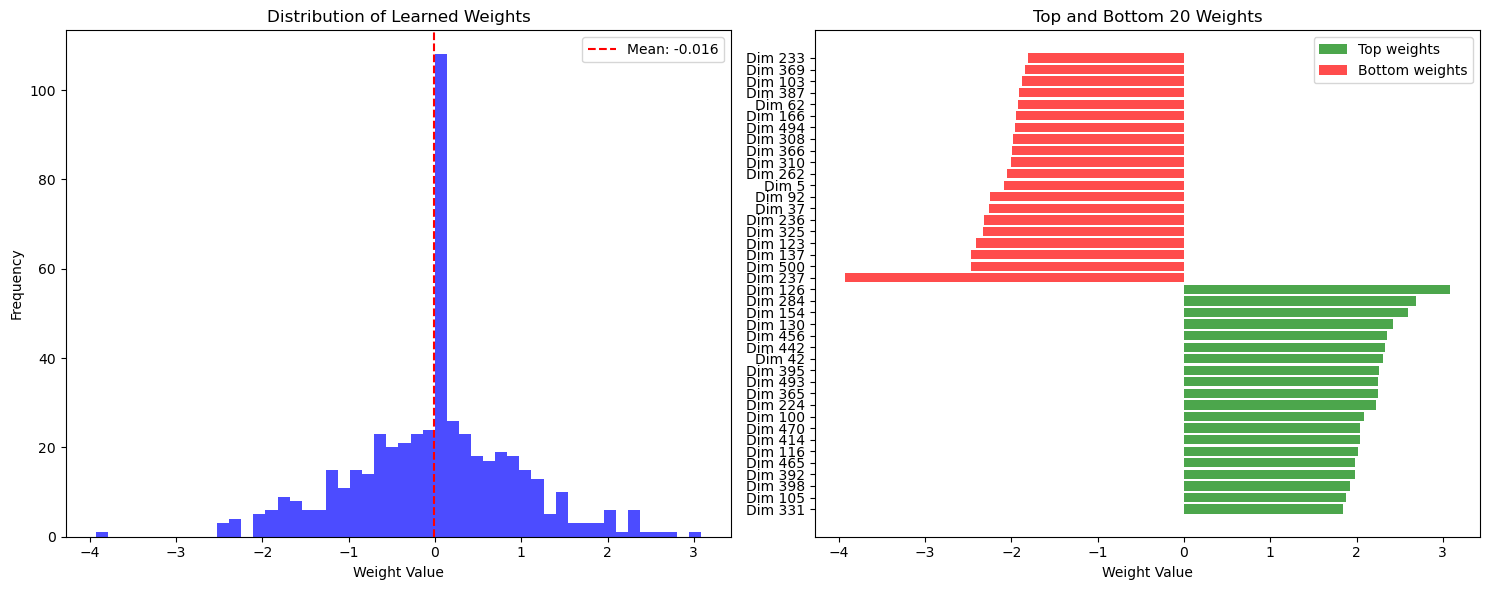


Weight Statistics:
Mean: -0.0157
Std: 0.9532
Min: -3.9277 (Dimension 237)
Max: 3.0803 (Dimension 331)

Number of weights > 0.1: 194
Number of weights < 0.1: 318
Number of weights ≈ 0 (|w| < 0.1): 123


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the learned weights
learned_weights = model.weights.detach().numpy()


# Sort weights by magnitude for better visualization
sorted_indices = np.argsort(learned_weights)
sorted_weights = learned_weights[sorted_indices]

# Create figure
plt.figure(figsize=(15, 6))

# Main weight distribution plot
plt.subplot(1, 2, 1)
plt.hist(learned_weights, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Learned Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.axvline(x=learned_weights.mean(), color='red', linestyle='--', label=f'Mean: {learned_weights.mean():.3f}')
plt.legend()

# Top/bottom weights plot
plt.subplot(1, 2, 2)
n_top = 20  # number of top/bottom weights to show

# Plot top and bottom weights
plt.barh(range(n_top), sorted_weights[-n_top:], color='green', alpha=0.7, label='Top weights')
plt.barh(range(n_top, 2*n_top), sorted_weights[:n_top], color='red', alpha=0.7, label='Bottom weights')

plt.yticks(range(2*n_top), 
          [f'Dim {sorted_indices[-i-1]}' for i in range(n_top)] + 
          [f'Dim {sorted_indices[i]}' for i in range(n_top)])
plt.title(f'Top and Bottom {n_top} Weights')
plt.xlabel('Weight Value')
plt.legend()

plt.tight_layout()
plt.show()

# Print some summary statistics
print("\nWeight Statistics:")
print(f"Mean: {learned_weights.mean():.4f}")
print(f"Std: {learned_weights.std():.4f}")
print(f"Min: {learned_weights.min():.4f} (Dimension {sorted_indices[0]})")
print(f"Max: {learned_weights.max():.4f} (Dimension {sorted_indices[-1]})")

# Count weights approximately equal to 0
epsilon = 0.1  # You can adjust this threshold as needed
print(f"\nNumber of weights > {epsilon}: {np.sum(learned_weights > epsilon)}")
print(f"Number of weights < {epsilon}: {np.sum(learned_weights < epsilon)}")


zero_weights = np.sum(np.abs(learned_weights) < epsilon)
print(f"Number of weights ≈ 0 (|w| < {epsilon}): {zero_weights}")

In [17]:
np.save('learned_cosine_weights.npy', learned_weights)

Baseline un-weighted cosine sim score.

In [18]:
def evaluate_cosine_baseline(pairs_data, embeddings, weights=None):
    sigmoid = nn.Sigmoid()
    all_preds = []
    all_labels = []
    
    for i, j, label in pairs_data:
        emb1 = embeddings[i].unsqueeze(0)
        emb2 = embeddings[j].unsqueeze(0)
        
        # Apply weights if provided
        if weights is not None:
            emb1 = emb1 * weights
            emb2 = emb2 * weights
        
        # Calculate cosine similarity and apply sigmoid
        cos_sim = nn.functional.cosine_similarity(emb1, emb2)
        output = sigmoid(cos_sim)
        
        # Convert to binary prediction
        pred = (output > 0.5).float()
        
        all_preds.append(pred.item())
        all_labels.append(label)
    
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    f1 = f1_score(all_labels, all_preds)
    
    return accuracy, f1

# Test unweighted version
train_acc, train_f1 = evaluate_cosine_baseline(train_pairs_data, embeddings)
test_acc, test_f1 = evaluate_cosine_baseline(test_pairs_data, embeddings)

print(f'Unweighted Baseline Train - Acc: {train_acc:.4f}, F1: {train_f1:.4f}')
print(f'Unweighted Baseline Test  - Acc: {test_acc:.4f}, F1: {test_f1:.4f}')

Unweighted Baseline Train - Acc: 0.6598, F1: 0.6989
Unweighted Baseline Test  - Acc: 0.6595, F1: 0.7006


In [26]:
# This completely removes dims with less than threshold magnitude weight
def evaluate_cosine_baseline_with_threshold(pairs_data, embeddings, weights=None, threshold=1):
    sigmoid = nn.Sigmoid()
    all_preds = []
    all_labels = []
    
    # If weights provided, create mask for significant dimensions
    if weights is not None:
        significant_dims = torch.abs(weights) >= threshold
        # Filter embeddings and weights to only keep significant dimensions
        filtered_weights = weights[significant_dims]
    
    for i, j, label in pairs_data:
        emb1 = embeddings[i].unsqueeze(0)
        emb2 = embeddings[j].unsqueeze(0)
        
        if weights is not None:
            # Filter to significant dimensions
            emb1 = emb1[:, significant_dims]
            emb2 = emb2[:, significant_dims]
            # Apply remaining weights
            emb1 = emb1 * filtered_weights
            emb2 = emb2 * filtered_weights
        
        # Calculate cosine similarity and apply sigmoid
        cos_sim = nn.functional.cosine_similarity(emb1, emb2)
        output = sigmoid(cos_sim)
        
        pred = (output > 0.5).float()
        all_preds.append(pred.item())
        all_labels.append(label)
    
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    f1 = f1_score(all_labels, all_preds)
    
    # Calculate how many dimensions were kept
    if weights is not None:
        dims_kept = significant_dims.sum().item()
        dims_total = len(weights)
        print(f'Dimensions kept: {dims_kept}/{dims_total} ({(dims_kept/dims_total)*100:.1f}%)')
    
    return accuracy, f1

# Test unweighted version
train_acc, train_f1 = evaluate_cosine_baseline_with_threshold(train_pairs_data, embeddings, torch.tensor(learned_weights))
test_acc, test_f1 = evaluate_cosine_baseline_with_threshold(test_pairs_data, embeddings, torch.tensor(learned_weights))

print(f'Weighted Baseline Train - Acc: {train_acc:.4f}, F1: {train_f1:.4f}')
print(f'Weighted Baseline Test  - Acc: {test_acc:.4f}, F1: {test_f1:.4f}')



Dimensions kept: 143/512 (27.9%)
Dimensions kept: 143/512 (27.9%)
Weighted Baseline Train - Acc: 0.6515, F1: 0.6984
Weighted Baseline Test  - Acc: 0.6503, F1: 0.6988


ROC Curve unweighted vs weighted

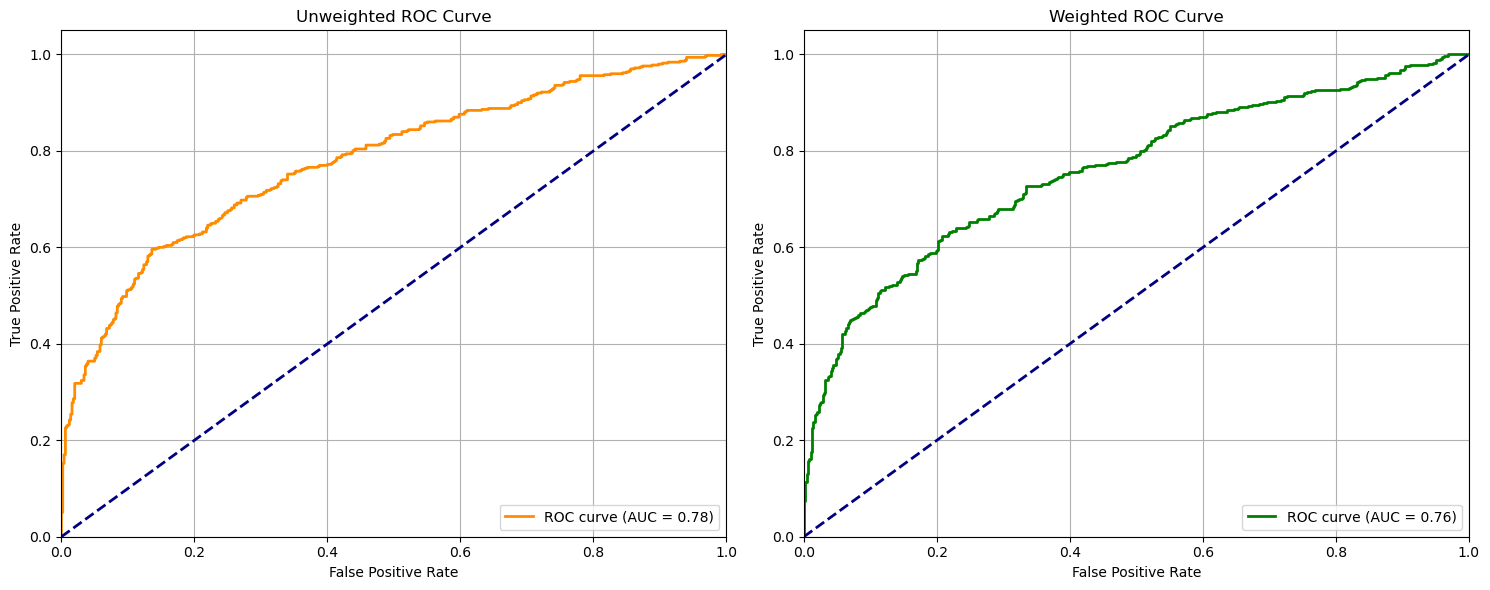

AUC improvement: -0.0200


In [29]:
def plot_roc_comparison(eval_loader, learned_weights):
    def get_predictions(dataloader, weights=None):
        all_probs = []
        all_labels = []
        
        for batch in dataloader:
            emb1 = batch['emb1']
            emb2 = batch['emb2']
            labels = batch['label']
            
            if weights is not None:
                # Apply weights
                emb1 = emb1 * torch.from_numpy(weights)
                emb2 = emb2 * torch.from_numpy(weights)
            
            # Compute cosine similarity
            cos_sim = nn.functional.cosine_similarity(emb1, emb2, dim=1)
            probs = torch.sigmoid(cos_sim).cpu().numpy()
            
            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy())
        
        return np.array(all_probs), np.array(all_labels)

    # Get predictions for both weighted and unweighted
    weighted_probs, true_labels = get_predictions(eval_loader, learned_weights)
    unweighted_probs, _ = get_predictions(eval_loader)

    # Calculate ROC curves
    fpr_weighted, tpr_weighted, _ = roc_curve(true_labels, weighted_probs)
    fpr_unweighted, tpr_unweighted, _ = roc_curve(true_labels, unweighted_probs)
    
    roc_auc_weighted = auc(fpr_weighted, tpr_weighted)
    roc_auc_unweighted = auc(fpr_unweighted, tpr_unweighted)

    # Create side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot unweighted ROC
    ax1.plot(fpr_unweighted, tpr_unweighted, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc_unweighted:.2f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Unweighted ROC Curve')
    ax1.legend(loc="lower right")
    ax1.grid(True)

    # Plot weighted ROC
    ax2.plot(fpr_weighted, tpr_weighted, color='green', lw=2,
             label=f'ROC curve (AUC = {roc_auc_weighted:.2f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Weighted ROC Curve')
    ax2.legend(loc="lower right")
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    return roc_auc_unweighted, roc_auc_weighted

# Usage:
learned_weights = model.weights.detach().numpy()
unweighted_auc, weighted_auc = plot_roc_comparison(eval_loader, learned_weights)
print(f'AUC improvement: {weighted_auc - unweighted_auc:.4f}')

Neural Representation Instead

In [20]:
class EmbeddingNN(nn.Module):
    def __init__(self, input_dim, layer_sizes):
        super().__init__()
        
        # Build layers based on input list
        layers = []
        current_dim = input_dim
        
        # If single layer, just do direct projection
        if len(layer_sizes) == 1:
            layers.append(nn.Linear(current_dim, layer_sizes[0]))
        # If multiple layers, add ReLU between them
        else:
            for size in layer_sizes[:-1]:
                layers.extend([
                    nn.Linear(current_dim, size),
                    nn.ReLU()
                ])
                current_dim = size
            # Add final projection layer
            layers.append(nn.Linear(current_dim, layer_sizes[-1]))
        
        self.projection = nn.Sequential(*layers)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, emb1, emb2):
        proj1 = self.projection(emb1)
        proj2 = self.projection(emb2)
        
        cos_sim = nn.functional.cosine_similarity(proj1, proj2, dim=1)
        return self.sigmoid(cos_sim)

In [21]:
# Prepare data and train
train_pairs_data, embeddings = prepare_data(train_pairs, train_nonpairs, network_vector_df)
test_pairs_data, _ = prepare_data(test_pairs, test_nonpairs, network_vector_df)

train_dataset = PairDataset(train_pairs_data, embeddings)
test_dataset = PairDataset(test_pairs_data, embeddings)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

modelNN = EmbeddingNN(input_dim=512, layer_sizes=[5])

In [22]:
modelNN = train_model(modelNN, train_loader, test_loader, num_epochs=5, learning_rate=1e-4)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch 1:
Train - Loss: 0.6003, Acc: 0.6917, F1: 0.7456
Val   - Loss: 0.6059, Acc: 0.6822, F1: 0.7397

Epoch 2:
Train - Loss: 0.5961, Acc: 0.6981, F1: 0.7501
Val   - Loss: 0.6032, Acc: 0.6867, F1: 0.7431

Epoch 3:
Train - Loss: 0.5947, Acc: 0.6990, F1: 0.7525
Val   - Loss: 0.6026, Acc: 0.6859, F1: 0.7439

Epoch 4:
Train - Loss: 0.5940, Acc: 0.7020, F1: 0.7541
Val   - Loss: 0.6020, Acc: 0.6877, F1: 0.7449

Epoch 5:
Train - Loss: 0.5937, Acc: 0.7021, F1: 0.7534
Val   - Loss: 0.6015, Acc: 0.6901, F1: 0.7457



In [23]:
# Prepare evaluation data
eval_pairs_data, _ = prepare_data(eval_pairs, eval_nonpairs, network_vector_df)
eval_dataset = PairDataset(eval_pairs_data, embeddings)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

# Run evaluation
eval_acc, eval_f1, eval_loss = evaluate_model(modelNN, eval_loader)
print(f'Evaluation Results:')
print(f'Accuracy: {eval_acc:.4f}')
print(f'F1 Score: {eval_f1:.4f}')
print(f'Loss: {eval_loss:.4f}')

Evaluation Results:
Accuracy: 0.6890
F1 Score: 0.7457
Loss: 0.6050


In [25]:
torch.save(modelNN, 'neural_rep_network.pt')